# Intro

The field of Natural Language Processing (NLP) has a lot more to offer than just "Language Models" that generate text, but to keep it simple we will focus on that part.

To understand how Large Language Models (LLMs) work a foundation in Deep Learning is necessary as well, a great YouTube series that goes from Deep Learning up until LLMs (ChatGPT in particular), can be found here:  
[3 Blue 1 Brown - series on DL + LLMs](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)


A great course on programming topics around LLMs will be [here](https://github.com/karpathy/LLM101n?tab=readme-ov-file) from Andrej Karapathy, currently under developement.



## A full Language Model example
We will use a "Small Language Model" as we can run it easily on our CPU or in Colab to do some fun first experiments.  Not sure if there even as a threshold when to consider a model "large", but for now let's call models above like 7 billion parameter "Large Language Models"
Model Source: https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct

In [ ]:
# %pip install transformers
# %pip install scikit-learn
# %pip install matplotlib
# %pip install seaborn

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch import no_grad, argmax, triu, ones
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import numpy as np
import seaborn as sns

In [ ]:
checkpoint = "HuggingFaceTB/SmolLM-135M-Instruct"

device = "cpu" # for GPU usage "cuda" or for CPU usage "cpu"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
model

In [ ]:
messages = [{"role": "user", "content": "What is the capital of France."}]
input_text=tokenizer.apply_chat_template(messages, tokenize=False)
print(input_text)
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
print(tokenizer.decode(outputs[0]))

## Breaking it down step by step

### 1. Tokenization

is the process of splitting a piece of text into smaller units, called tokens. These tokens can be words, characters, or subwords, depending on the level of granularity you want. In the context of NLP, tokens are typically words or meaningful units of text. For Language Models words or subwords are often used. For a model to be able to use these tokens they need to be mapped to a number.

The simplest tokenizer would be a lookup table for characters. In a "useful" LM tokenizers are a bit more complex and usually use subwords.

In [ ]:
dict(list(tokenizer.vocab.items())[:5])

In [ ]:
len(tokenizer.vocab)

In [ ]:
tokenizer.vocab["Hello"]

In [ ]:
try: tokenizer.vocab["Hell"]
except Exception as e: print(type(e),str(e))

print(tokenizer.encode("Hell"))
print(tokenizer.vocab["H"])
print(tokenizer.vocab["ell"])

In [ ]:
print(tokenizer.encode("Hello"))
print(tokenizer.encode("Hello,"))
print(tokenizer.encode("Hello, World"))
print(tokenizer.encode("Hello, World!"))

In [ ]:
tokenizer.special_tokens_map

In [ ]:
print(tokenizer.vocab["<|im_start|>"])
print(tokenizer.vocab["<|im_end|>"])

In [ ]:
messages = [{"role": "user", "content": "What is the capital of France."}]
print(tokenizer.apply_chat_template(messages, tokenize=False))

In [ ]:
messages = [{"role": "user", "content": "What is the capital of France."}, {"role": "assistant", "content": "It is Paris."}]
print(tokenizer.apply_chat_template(messages, tokenize=False))
print(tokenizer.apply_chat_template(messages))

### 2. Embeddings
In very simple terms, an embedding is a multi-dimensional vector that is supposed to encode the meaning of the text it belongs to.
We can create embedding vectors for words/tokens and even for full sentences. The embedding layer of the model we investigate here has an embedding dimension of 576.
In theory you can try and think of each dimension in an embedding vector to represent an attribute of the word it is encoding, e.g. is it male?, is it a noun?, is it a country?, ...  
In practice it is unclear what exactly this embeddings represent and there is a large body of research around making these things more explainable.

In this section we take a look at the embedding layer of our model and try to visualize what it does.

In [ ]:
input_ids = tokenizer.encode("Hello, World!", return_tensors="pt")
input_ids

In [ ]:
# Extract the embedding layer from the model
embedding_layer = model.model.embed_tokens
# Get the output after the embedding layer
with no_grad():
    embeddings_output = embedding_layer(input_ids)
print(embeddings_output.shape)
embeddings_output

In [ ]:
words = [
    "Cat",
    "Dog",
    "Bird",
    "Machine",
    "Car"
]

sentences = [
    "The cat sat on the table.",
    "The hamster lay on the mat.",
    "Birds fly high in the sky.",
    "Cats fly high in the sky.",
    "Machine Learning is cool.",
]

def create_embeddings(inputs: list):
    # Tokenize and encode the sentences
    input_ids = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True)['input_ids'].to(device)
    with no_grad():
        embeddings = model.model.embed_tokens(input_ids)
    print(embeddings.size())
    # Average embeddings across the sequence length in case of sentences
    embeddings = embeddings.mean(dim=1).cpu().numpy()
    # embeddings = embeddings.reshape(-1, embeddings.size()[-1])
    print(embeddings.shape)
    return embeddings

def plot_embeddings(inputs, embeddings, compare_embeddings = None):
    # Reduce dimensions to 2D using PCA for visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=100)

    # Annotate points with the sentences
    for i, elem in enumerate(inputs):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], elem, fontsize=12)
    
    if compare_embeddings is not None:
        reduced_compare_embeddings = pca.fit_transform(compare_embeddings)
        plt.scatter(reduced_compare_embeddings[:, 0], reduced_compare_embeddings[:, 1], c="green", s=100)


    plt.title("2-D PCA of Embeddings")
    plt.xticks([-2, -1, 0, 1, 2]) # Set fixed x-axis ticks
    # plt.yticks([-2, -1, 0, 1, 2]) # Set fixed y-axis ticks
    plt.grid(True)
    plt.show()

plot_embeddings(words, create_embeddings(words))

plot_embeddings(sentences, create_embeddings(sentences))

In [ ]:
shuffled_sentences = [' '.join(random.sample(sentence.split(), len(sentence.split()))) for sentence in sentences]
plot_embeddings(shuffled_sentences, create_embeddings(shuffled_sentences))

### 3. Positional Encoding

As you can see in the last example, the output of our embedding layer has a problem: It does not encode the order of words.
But to properly encode the full information of a sentence the order of words matters a lot. And since our LLM is supposed to correctly continue a sentence it needs to perfectly understand its meaning.

To resolve the missing information of order, LLMs use a Position Encoding that is "added" to the Embedding.

#### Classic Positional Encoding with Adjustable Constant \( C \)

To control the influence of positional information in transformer models, we use the following modified positional encoding formulas:

- Positional Encoding for Even Dimensions (\( i = 2k \)):

$
PE_{(pos, 2k)} = \sin\left(\frac{pos}{C^{\frac{2k}{d\_model}}}\right)
$

- Positional Encoding for Odd Dimensions (\( i = 2k+1 \)):

$
PE_{(pos, 2k+1)} = \cos\left(\frac{pos}{C^{\frac{2k}{d\_model}}}\right)
$

- The constant \( C \) controls the scaling of positional encoding frequencies across dimensions.
- **Larger \( C \) Values**: Result in slower changes in frequency across dimensions, emphasizing broader contextual information and capturing long-range dependencies.
- **Smaller \( C \) Values**: Result in faster changes in frequency, providing more detailed positional information and helping distinguish close-by positions more effectively.  
The original formula from the Transformer paper uses C=10000 we use C=1 to better visualize our short text examples.

#### RoPE - improved Positional Encoding
Since the model we investigate here is a state of the art LLM it uses [RoPE](https://arxiv.org/abs/2104.09864). But even though it works better, it is harder to visualize, so to explain the concept we use the classical one for the next few examples.

In [ ]:
def add_positional_encoding(embeddings):
    """
    Adds positional encoding to token embeddings.

    Parameters:
    token_embeddings (np.ndarray): The token embeddings of shape (seq_len, d_model).
    positional_encodings (np.ndarray): The positional encodings of shape (seq_len, d_model).

    Returns:
    np.ndarray: The embeddings with positional encodings added.
    """
    def positional_encoding(seq_len, d_model):
        """
        Generates positional encoding matrix.

        Parameters:
        seq_len (int): The length of the sequence (number of tokens).
        d_model (int): The dimension of the embeddings.

        Returns:
        np.ndarray: The positional encoding matrix of shape (seq_len, d_model).
        """
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        oscillator = 1
        angles = pos / np.power(oscillator, (2 * (i // 2)) / np.float32(d_model))
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        return angles

    return embeddings * positional_encoding(embeddings.shape[0], embeddings.shape[1])

In [ ]:
plot_embeddings(sentences, create_embeddings(sentences), create_embeddings(shuffled_sentences))

In [ ]:
plot_embeddings(sentences, add_positional_encoding(create_embeddings(sentences)), add_positional_encoding(create_embeddings(shuffled_sentences)))

### 4. Attention

**Attention** is a mechanism used in machine learning, especially in natural language processing, to help models focus on the most relevant parts of the input data when making decisions. Imagine you are reading a long text; instead of trying to understand everything at once, attention allows you to selectively focus on key words or sentences that are crucial for understanding the context. Similarly, in neural networks, attention helps the model to give different levels of importance to different parts of the input, which improves its ability to handle complex tasks like translation or summarization by effectively "paying attention" to the right information at the right time. This leads to better performance and more accurate results.

#### Some code to help visualize what attention does

In [ ]:
def decode_output(output):
    # Assume you have the following logits from your model output with Shape: [1, sequence_length, vocab_size]
    # Step 1: Extract the logits for the last token in the sequence
    last_token_logits = output.logits[:, -1, :]  # Shape: [1, vocab_size]
    # Step 2: Apply softmax to get probabilities
    probs = F.softmax(last_token_logits, dim=-1)  # Shape: [1, vocab_size]
    # Step 3: Get the token with the highest probability
    predicted_token_id = argmax(probs, dim=-1)  # Shape: [1]
    # Convert the token id to a human-readable token (if needed)
    predicted_token = tokenizer.decode(predicted_token_id[0].item())
    return predicted_token

# Hook to store weights of attention during forward pass
class AttentionWeightsHook:
    def __init__(self):
        self.attention_weights = []
    
    def __call__(self, module, input, output):
        self.attention_weights.append(output[0])

def forward_with_attention_weights(input_ids):   
    # Create hook and attach it to the attention layers
    hook = AttentionWeightsHook()
    hooks = []
    for layer in model.model.layers:
        hook_handle = layer.self_attn.register_forward_hook(hook)
        hooks.append(hook_handle)
    # Forward pass
    with no_grad():
        predicted_token = decode_output(model(input_ids))
    # Remove hooks after the forward pass
    for handle in hooks:
        handle.remove()

    return predicted_token, hook.attention_weights

def plot_attention_weights(attention_weights, input_ids, layer_idx):
    """
    Plot the attention weights of a specific layer and head.

    Parameters:
    - attention_weights: List of attention weights from the hook.
    - layer_idx: Index of the layer to visualize.
    - head_idx: Index of the attention head to visualize.
    """
    # Extract the weights for the specific layer and head   
    weights = attention_weights[layer_idx].squeeze()
    att = weights @ weights.T # multiply attention weights to get input_size x input_size matrix
    # TODO: comment this out to show correctly masked attention
    # att = att * (1 - triu(ones(att.shape[0], att.shape[1]), diagonal=1)) # mask out attention so tokens can not look into the future
    tokens = [tokenizer.decode(_id) for _id in input_ids.squeeze()]
    plt.figure(figsize=(10, 8))
    sns.heatmap(att.numpy(), xticklabels=tokens, yticklabels=tokens)
    plt.title(f'Attention Weights - Layer {layer_idx}')
    plt.xlabel('Input Token')
    plt.ylabel('Input Token')
    plt.show()

from IPython.display import clear_output
from time import sleep

def generate_with_attn_plot(input_sentence, layer_idx, num_tokens = 1, animate = False):
    for i in range(num_tokens):
        input_ids = tokenizer.encode(input_sentence, return_tensors="pt")
        predicted_token, attention_weights = forward_with_attention_weights(input_ids)
        plot_attention_weights(attention_weights, input_ids, layer_idx)
        print(f"Predicted token: {predicted_token}")
        input_sentence += predicted_token
        if animate:
            sleep(0.2)
            clear_output(wait=True)



#### A concrete example to show attention works

You can change the layer_idx to -1 to see the output of the last attention layer which also explains why the first 2 examples still work (output is 4) and the last one does not.

In [ ]:
# Example usage
layer_idx = 0  # Index of the attention layer
input_sentence = " 2 + 2 = "
generate_with_attn_plot(input_sentence, layer_idx, num_tokens=1)
input_sentence = " noise noise noise 2 + 2 = "
generate_with_attn_plot(input_sentence, layer_idx, num_tokens=1)
input_sentence = " 2 + 2 noise noise noise = "
generate_with_attn_plot(input_sentence, layer_idx, num_tokens=1)

### 5. Multi Layer Perceptron

Looking model architecture, within each `LlamaDecoderLayer`, after **Attention** there is an **MLP block** which plays a critical role in processing information after the self-attention mechanism.

In [ ]:
model

#### Here's a breakdown of the MLP Blocks function:

After the self-attention mechanism identifies and processes the relevant parts of the input, the **MLP (Multi-Layer Perceptron) block** helps to further transform and refine the information. It does this by applying a series of linear transformations and non-linear activations to the output from the attention layer. In the Llama model, the MLP block consists of:

1. **Linear Layers (Gate, Up, and Down Projections)**: 
   - The `gate_proj` and `up_proj` layers are used to increase the dimensionality of the input (from 576 to 1536 in this case), allowing the network to learn more complex representations. 
   - The `down_proj` layer then reduces the dimensionality back to the original size (from 1536 to 576), ensuring the output size matches the input size of the layer, which is necessary for the residual connections (skip connections) to work properly.

2. **Activation Function (SiLU)**: 
   - The activation function introduces non-linearity, enabling the network to learn more complex patterns. The SiLU (Sigmoid Linear Unit) function is used here, which is a smooth and differentiable activation function that performs well in deep networks.

##### Why is it Important

The MLP block allows the model to combine and re-integrate the information captured by the attention mechanism in a more expressive and powerful way. While the attention mechanism excels at finding relationships and dependencies in the data, the MLP block refines these insights by applying learned transformations, enabling the model to make nuanced and accurate predictions. Together, the self-attention and MLP blocks enable the model to effectively process and generate text, making them essential components of modern transformer-based architectures like Llama.

This is difficult to visualize we will attempt to do so by looking at the first (0) and last layer (29) of the Decoder Blocks to see how the attion changes when being processed by all the MLP Blocks.

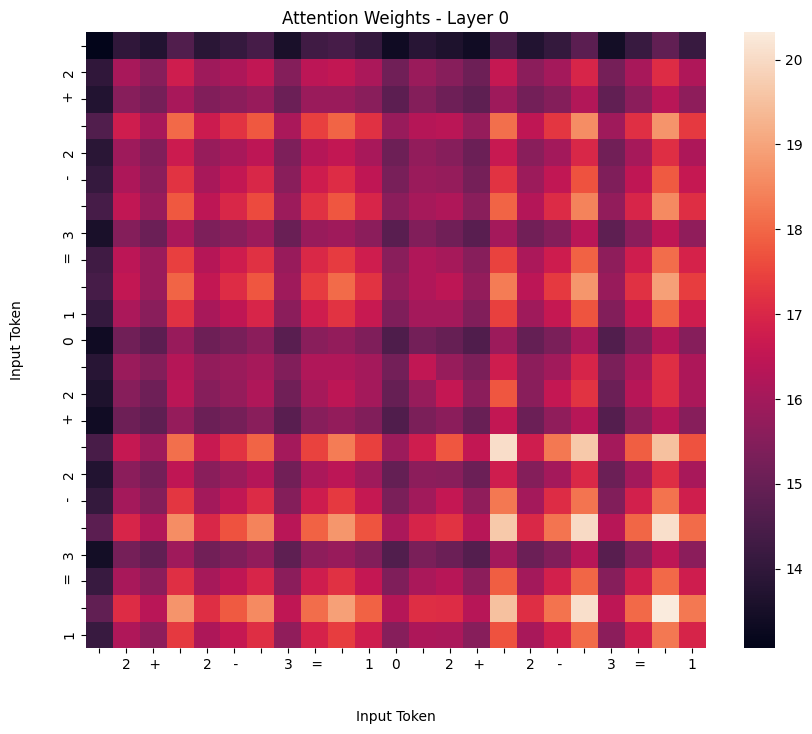

Predicted token: 0


In [104]:
input_sentence = " 2 + 2 - 3 = "
generate_with_attn_plot(input_sentence, layer_idx=0, num_tokens=15, animate=True)

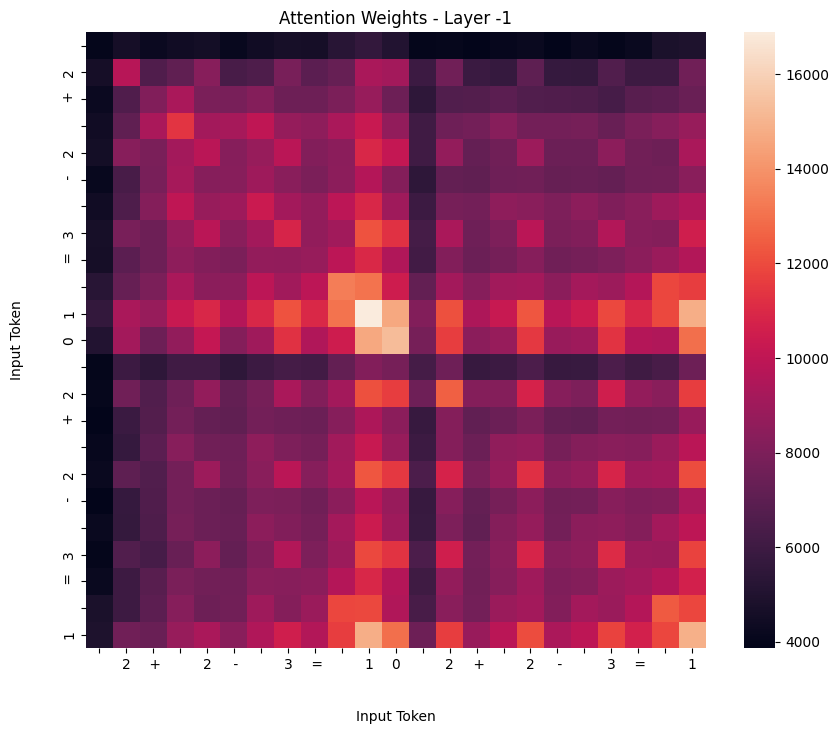

Predicted token: 0


In [105]:
generate_with_attn_plot(input_sentence, layer_idx=-1, num_tokens=15, animate=True)

#### Interpretation

In the first layer of attention the model has grasped roughly how to inputs belong together, but looking at the last layer you can clearly see that for example the whitespace between the first equeation and the second in starts to generate does not need to be attended to as it contains no information.  
This is the kind of information that is stored/learned within the weights of the MLP blocks, "whitespaces do not matter for mathematical equations".

### 6. The Linear layer

The **`Linear`** layer in a language model is the final step in the model that converts the abstract representations generated by the neural network into actual words or tokens. Here's how it works:

1. **Purpose**: After the model processes the input text through various layers, including attention and MLP blocks, it generates a numerical representation of what it believes should come next in the sequence. The `Linear` layer transforms these numerical representations into probabilities for each possible word or token in the vocabulary.

2. **Linear Transformation**: The `Linear` layer is a linear layer (a type of fully connected layer), which means it performs a matrix multiplication to convert the final hidden state (of size 576 in this case) into logits --> a raw score for each token in the vocabulary. This is done using a weight matrix of size 576 by 49152, where 49152 corresponds to the size of the vocabulary.

3. **Output**: The output of the `Linear` layer is a vector of scores, each representing the likelihood of a particular token being the next one in the sequence. These scores are then typically passed through a softmax function to turn them into probabilities, which are used to predict the next token in tasks like text generation.

In summary, the `Linear` layer is crucial because it takes the complex internal representations created by the model and maps them to a space where they can be interpreted as meaningful predictions about which words or tokens are likely to come next.

In [106]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm

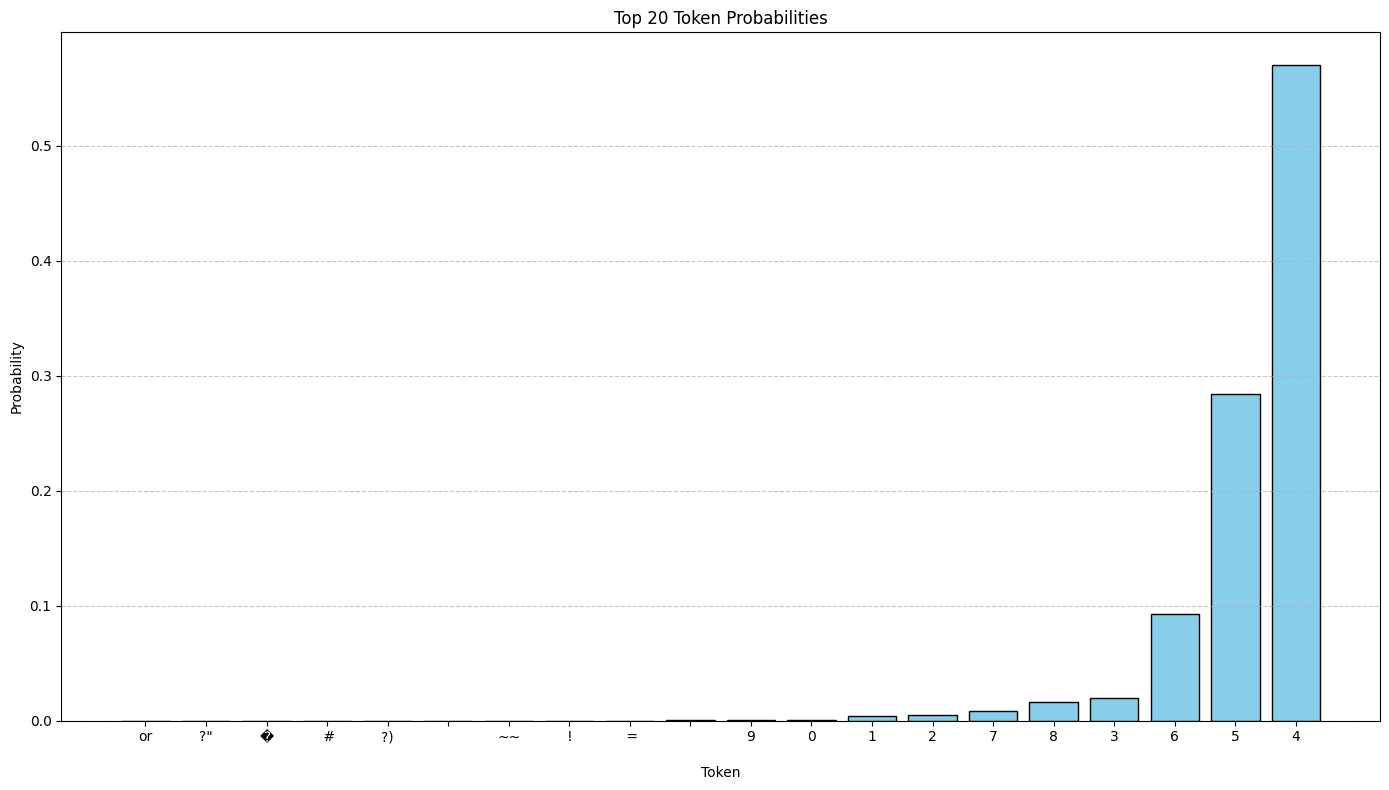

In [118]:
input_sentence = " 2 + 2 = "
input_ids = tokenizer.encode(input_sentence, return_tensors="pt")

with no_grad(): 
    output = model(input_ids)

# Extract the logits for the last token
last_token_logits = output.logits[:, -1, :]  # Shape: [1, vocab_size]

# Convert logits to probabilities
probs = F.softmax(last_token_logits, dim=-1)  # Shape: [1, vocab_size]

# Convert probabilities to numpy array for visualization
probs = probs.squeeze().numpy()

# Example: Visualize top 20 probabilities
top_k = 20
top_k_indices = np.argsort(probs)[-top_k:]
top_k_probs = probs[top_k_indices]
top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices]

plt.figure(figsize=(14, 8))
plt.bar(top_k_tokens, top_k_probs, color='skyblue', edgecolor='black')
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title(f'Top {top_k} Token Probabilities')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()